In [1]:
from google.colab import drive
drive.mount('/content/drive')
path_ml_100k = '/content/drive/MyDrive/ml-100k'
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder



user = pd.read_csv(os.path.join(path_ml_100k, 'u.user'), header = None, sep = "|")
user.columns = ["user_id","age","gender","occupation","zipcode"]
user = user.drop(["zipcode"], axis = 1)
bins = [0, 20, 30, 40, 50, 60, np.inf]
names = ['<20', '20-29', '30-39','40-49', '51-60', '60+']

user['agegroup'] = pd.cut(user['age'], bins, labels=names)
user = user.drop(["age"], axis = 1)
user['user_id'] = user['user_id'] - 1
user.head()

columnsToEncode = ["agegroup","gender","occupation"]
myEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
myEncoder.fit(user[columnsToEncode])

user_features = pd.concat([user.drop(columnsToEncode, 1),
                           pd.DataFrame(myEncoder.transform(user[columnsToEncode]), 
                                        columns = myEncoder.get_feature_names(columnsToEncode))], axis=1).reindex().set_index('user_id')

user_features.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,agegroup_20-29,agegroup_30-39,agegroup_40-49,agegroup_51-60,agegroup_60+,agegroup_<20,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,occupation_healthcare,occupation_homemaker,occupation_lawyer,occupation_librarian,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Movie Data (Arm)

In [2]:
movie = pd.read_csv(os.path.join(path_ml_100k, 'u.item'), header = None, sep = "|", encoding='latin-1')
movie.columns = ["movie_id", "movie_title", "release_date", "video_release_date", "IMDb_URL", 
                  "unknown", "Action", "Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy",
                  "Film-Noir","Horror", "Musical", "Mystery","Romance","Sci-Fi","Thriller", "War","Western"]
movie_features = movie.drop(["movie_title","release_date", "video_release_date", "IMDb_URL"],axis = 1).set_index('movie_id')
movie_features.head()

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


## RATINGS

In [3]:
data = pd.read_csv(os.path.join(path_ml_100k, 'u.data'), sep ="\t", header=None, names = ["user_id", "movie_id","rating", "timestamp"])
data = data.drop(["timestamp"], axis = 1)

n = 30
# Obtain top movies index
data['user_id'] = data['user_id'] - 1
top_movies_index = data.groupby("movie_id").count().sort_values("user_id", ascending = False).head(n).reset_index()["movie_id"]
top_movies_features = movie_features[movie_features.index.isin(top_movies_index)]


filtered_data_original = data[data["movie_id"].isin(top_movies_index)]

filtered_data_original["reward"] = np.where(filtered_data_original["rating"] < 5,0,1)

filtered_data_original = filtered_data_original.reset_index(drop = True)

filtered_data_original

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,user_id,movie_id,rating,reward
0,199,222,5,1
1,307,1,4,0
2,300,98,4,0
3,250,100,4,0
4,24,181,5,1
...,...,...,...,...
11990,362,181,5,1
11991,779,50,5,1
11992,129,121,5,1
11993,820,151,4,0


In [4]:
print("PERCENTAGE MISSING DATA : ", (1 - len(filtered_data_original) / (len(filtered_data_original.user_id.drop_duplicates()) * len(filtered_data_original.movie_id.drop_duplicates()))) * 100)

PERCENTAGE MISSING DATA :  57.4645390070922


In [5]:
selected_movies = sorted(filtered_data_original.movie_id.drop_duplicates())
nb_movies = len(selected_movies)
total_movies = len(movie_features)
selected_users = sorted(filtered_data_original.user_id.drop_duplicates())
nb_users = len(selected_users)
total_users = len(user_features)

user_features['key'] = 1
movie_features['key'] = 1
cross_tab = pd.merge(user_features, movie_features,on='key').drop(columns = ['key']).values.reshape(total_movies, total_users , 48)
user_features.drop(columns = ['key'], inplace = True)
movie_features.drop(columns = ['key'], inplace = True)
shuffled_df = filtered_data_original.sample(frac=1)

In [206]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import Ridge

def draw_reward(movie, user, phi, theta):
    """
    Generating reward for each arm
    """
    reward_user_movie = filtered_data_original[(filtered_data_original.movie_id == movie) & (filtered_data_original.user_id == user)]['reward']
    return reward_user_movie

def gradient(theta, t, phi, lambda_, r, a, u, training_ini):
    """
    Return gradient of the objective function
    """
    fact = (phi[a[t+1 - training_ini:t+1 ], u[t+1 - training_ini:t+1 ]].dot(theta) - r[t+1 - training_ini:t+1 ][:, None])
    #return 2 * np.einsum('ij,ik->k', fact, phi[a[t+1 - training_ini:t+1 ], u[t+1 - training_ini:t+1 ]])[:, None] / training_ini + 2*lambda_*theta
    #print((2*(fact * phi[a[t+1 - training_ini:t+1], u[t+1 - training_ini:t+1]]).sum(axis=0)/(training_ini)+ 2*lambda_*theta).shape)
    return (2*(fact * phi[a[t+1 - training_ini:t+1], u[t+1 - training_ini:t+1]]).sum(axis=0)/training_ini)[:, None] + 2*lambda_*theta

def update_theta(theta_estimate, t, phi, A, U, R, nu, n_iter, lambda_):
    """
    Update the estimate of theta with gradient descent
    """
    for _ in range(n_iter):
        theta_estimate = theta_estimate - nu * gradient(theta_estimate, t, phi, lambda_, R, A, U, training_ini)
    return theta_estimate


def BGE(C, N):
    """
    Return eta, beta for the BGE scheduler
    """
    mask_positive = (N > 0)
    beta = np.empty_like(N)
    beta[mask_positive] = C * np.sqrt(N[mask_positive])
    beta[~mask_positive] = C
    return 1, beta, True

def choose_arm(theta_estimate, phi, eta, beta, sampling_gumbel, u):
    """
    Choose arm with gumbel uncertainty
    """
    mu_user = np.dot(phi[:, u], theta_estimate)
    beta_user = beta[:, u][:, None]
    
    available_movies = shuffled_df[shuffled_df.user_id == u].movie_id.values
    gum = np.ones((total_movies, 1))
    
    if sampling_gumbel:
        for j in range(total_movies):
            gum[j] = np.random.gumbel(loc=0, scale=1)
    
    I = beta_user * gum + eta * mu_user
    I_argmax = np.argmax(I[available_movies])
    return available_movies[I_argmax]



def bandit(C, generate_eta_beta, phi, theta0, nu, training_ini, n_iter_grad, lambda_):
    """
    Simulate bandit algorithm
    """
    # Cumulative reward for each arm
    R = np.zeros(len(shuffled_df))
    # Number of time armed pulled
    N = np.zeros((total_movies, total_users))
    # Stored actions
    A = -1 * np.ones(len(shuffled_df), dtype=np.int)
    U = -1 * np.ones(len(shuffled_df), dtype=np.int)
    theta_estimate = theta0
    list_estimates = []
    # L2 distance for theta
    count = 0
    for idx, row in shuffled_df.head(training_ini).iterrows():
        if count % 100 == 0 :
            print(count, len(shuffled_df))

        # Uncertainty :
        eta, beta, sampling_gumbel = generate_eta_beta(C, N)
        # Choose next user :
        u = row['user_id']
        # Choose arm:
        available_movies = shuffled_df[shuffled_df.user_id == u].movie_id.values
        arm = np.random.choice(available_movies)
        # Observe reward:
        reward = draw_reward(arm, u, phi, theta_estimate)

        # update parameters:
        N[arm, u] += 1
        R[count] = reward
        A[count] = arm
        U[count] = u
    
        count += 1


    sub_phi = phi[A[:training_ini], U[:training_ini]]
    sub_R = R[:training_ini]
    
    reg = Ridge(alpha = lambda_, fit_intercept=False)
    reg.fit(sub_phi, sub_R)

    theta_avg = reg.coef_
    theta_estimate = theta_avg.copy()[:, None]
    list_theta_estimate = [theta_estimate]
  

    for idx, row in shuffled_df.iloc[training_ini:].iterrows():
        if count % 100 == 0 :
            print(count, len(shuffled_df))
         # Uncertainty :
        eta, beta, sampling_gumbel = generate_eta_beta(C, N)
        # Choose next user :
        u = row['user_id']
        # Choose arm:
        available_movies = shuffled_df[shuffled_df.user_id == u].movie_id.values
        arm = choose_arm(theta_estimate, phi, eta, beta, sampling_gumbel, u)
        # Observe reward:
        reward = draw_reward(arm, u, phi, theta_estimate)
        
        if idx % training_ini == 0:
            theta_estimate = update_theta(theta_estimate, count, phi, A, U, R, nu = nu / (1 + idx // training_ini), n_iter = n_iter_grad, lambda_=lambda_)
            list_estimates.append(theta_estimate)
            theta_avg = np.mean(list_estimates, axis = 0)
            list_theta_estimate.append(theta_estimate)
        
        N[arm, u] += 1
        R[count] = reward
        A[count] = arm
        U[count] = u
        count += 1
    return theta_avg, N, R, A, U, list_theta_estimate



delta = 0.01
C = 0.25
theta0 = np.random.randn(48, 1)
nu = 5e-2
n_iter_grad = 1
lambda_ = 0.01
training_ini = 50
phi = cross_tab

theta_avg, N, R, A, U, list_theta_estimate = bandit(C, BGE, phi, theta0, nu, training_ini, n_iter_grad, lambda_)

0 11995
100 11995
200 11995
300 11995
400 11995


KeyboardInterrupt: ignored

Text(0.5, 1.0, 'L2 loss - BGE-SGD')

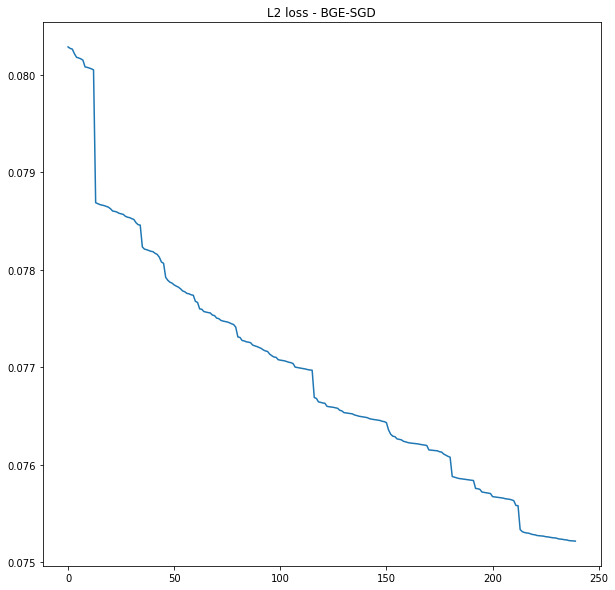

In [199]:
sub_phi = phi[A[(filtered_data_original.movie_id).values], U[(filtered_data_original.user_id).values]]
sub_r = filtered_data_original.reward.values
np.random.randn(48)

from sklearn.linear_model import Ridge
reg = Ridge(alpha = 0.01, fit_intercept=False)
reg.fit(sub_phi, sub_r)
true_theta = reg.coef_
plt.figure(figsize = (10, 10))
plt.plot([np.linalg.norm(true_theta - theta)/len(list_theta_estimate) for theta in list_theta_estimate])
plt.title('L2 loss - BGE-SGD')